In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preparation**

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [ ]:
# Download files from Google drive using sharable link,
# https://stackoverflow.com/a/50670037/7697658
if 'NIND' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1t5c3OUmHHDDvtpz4O-Gu_qrgggPxBAUW
    get_ipython().system_raw('7z x NIND.zip -o/content/ && rm NIND.zip')

Downloading...
From: https://drive.google.com/uc?id=1t5c3OUmHHDDvtpz4O-Gu_qrgggPxBAUW
To: /content/NIND.zip
3.22GB [00:30, 107MB/s] 


In [ ]:
# Download files from Google drive using sharable link,
# https://stackoverflow.com/a/50670037/7697658
if 'Mi3_Aligned' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1MrcCSnM3Weu7Wi-n0iNBxfFYlHy0ZUpX
    get_ipython().system_raw('7z x Mi3_Aligned.zip -o/content/ && rm Mi3_Aligned.zip')

Downloading...
From: https://drive.google.com/uc?id=1MrcCSnM3Weu7Wi-n0iNBxfFYlHy0ZUpX
To: /content/Mi3_Aligned.zip
2.71GB [00:45, 59.1MB/s]


In [ ]:
# Extract zip files to a destination directory,
# https://askubuntu.com/a/1049564
if 'SIDD_Small_sRGB_Only' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
    get_ipython().system_raw('7z x SIDD_Small_sRGB_Only.zip -o/content/ && rm SIDD_Small_sRGB_Only.zip')

Downloading...
From: https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
To: /content/SIDD_Small_sRGB_Only.zip
6.62GB [01:46, 62.4MB/s]


In [ ]:
def get_images_paths(root_dir_ssid, root_dir_mi, root_dir_nind):
    # Getting SSID dataset images
    root = pathlib.Path(root_dir_ssid)
    img_paths = list(root.rglob("*.PNG*"))
    img_paths_lst = [str(path) for path in img_paths]

    gt_lst = []
    noisy_lst= []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-3]
        if img_type=="NOISY":
            noisy_lst.append(p)
        elif img_type=="GT":
            gt_lst.append(p)

    # Getting mi dataset images
    root = pathlib.Path(root_dir_mi)
    img_paths = list(root.rglob("*.bmp*"))
    img_paths_lst = [str(path) for path in img_paths]

    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-1]
        if "Noisy" in img_type:
            noisy_lst.append(p)
        elif "Reference" in img_type:
            gt_lst.append(p)
            gt_lst.append(p)


    # Getting NIND dataset images
    root = pathlib.Path(root_dir_nind)
    img_paths = list(root.rglob("*.png*"))
    img_paths.extend(list(root.rglob("*.jpg*")))
    img_paths_lst = [str(path) for path in img_paths]

    for p in img_paths_lst:
        img_type = p.split("/")[-1].split("_")[-1]
        if "H" in img_type:
            noisy_lst.append(p)
        else:
            gt_lst.append(p)

    noisy_array = np.asarray(noisy_lst)
    gt_array = np.asarray(gt_lst)
    return noisy_array, gt_array

In [ ]:
from sklearn.model_selection import train_test_split

noisy_array_paths, gt_array_paths = get_images_paths("SIDD_Small_sRGB_Only", "Mi3_Aligned", "NIND")

noisy_train_paths, noisy_test_paths, gt_train_paths, gt_test_paths = train_test_split(noisy_array_paths, gt_array_paths, test_size=0.20, random_state=42)

In [ ]:
print(noisy_train_paths.shape)
print(noisy_test_paths.shape)
print(gt_train_paths.shape)
print(gt_test_paths.shape)

(241,)
(61,)
(241,)
(61,)


In [ ]:
# Get gt_images in memory
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        images_lst.append(img)
    return np.array(images_lst)

In [ ]:
noisy_train_images = get_images_in_mem(noisy_train_paths)
noisy_test_images = get_images_in_mem(noisy_test_paths)

gt_train_images = get_images_in_mem(gt_train_paths)
gt_test_images = get_images_in_mem(gt_test_paths)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)


(241, 256, 256, 3)
(61, 256, 256, 3)
(241, 256, 256, 3)
(61, 256, 256, 3)


# **PRIDNet Custom Layers**


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax
import cv2

tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_4 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')

    def call(self, X):
        X_1 = self.conv_1(X)
        X_1 = Activation('relu')(X_1)

        X_2 = self.conv_2(X_1)
        X_2 = Activation('relu')(X_2)

        X_3 = self.conv_3(X_2)
        X_3 = Activation('relu')(X_3)

        X_4 = self.conv_4(X_3)
        X_4 = Activation('relu')(X_4)
        
        #print('---conv block=',X_4.shape)
        
        return X_4

In [ ]:
class Channel_attention(tf.keras.layers.Layer):
    def __init__(self, C=64, **kwargs):
        super().__init__(**kwargs)
        self.C=C
        self.gap = GlobalAveragePooling2D()
        self.dense_middle = Dense(units=2, activation='relu')
        self.dense_sigmoid = Dense(units=self.C, activation='sigmoid')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        v = self.gap(X)
        #print("ca_ after gap =",v.shape)
        fc1 = self.dense_middle(v)
        #print("ca_ after fc1 =",fc1.shape)
        mu = self.dense_sigmoid(fc1)
        #print("ca_ after fc2 =",mu.shape)

        U_out = Multiply()([X, mu])
        
        #print('---channel attention block=',U_out.shape)

        return U_out

In [ ]:
class Avg_pool_Unet_Upsample_msfe(tf.keras.layers.Layer):
    def __init__(self, avg_pool_size, upsample_rate, **kwargs):
        super().__init__(**kwargs)
        # ---initialization for Avg pooling---
        self.avg_pool = AveragePooling2D(pool_size=avg_pool_size, padding='same')

        # --- initialization for Unet---
        self.deconv_lst = []
        filter=512
        for i in range(4):
            self.deconv_lst.append(Conv2DTranspose(filters=filter/2, kernel_size=[3, 3], strides=2, padding='same'))
            filter/=2

        self.conv_32_down_lst = []
        for i in range(4):
            self.conv_32_down_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_down_lst = []
        for i in range(4):
            self.conv_64_down_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_down_lst = []
        for i in range(4):
            self.conv_128_down_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_down_lst = []
        for i in range(4):
            self.conv_256_down_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_512_down_lst = []
        for i in range(4):
            self.conv_512_down_lst.append(Conv2D(filters=1024, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_32_up_lst = []
        for i in range(3):
            self.conv_32_up_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_up_lst = []
        for i in range(3):
            self.conv_64_up_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_up_lst = []
        for i in range(3):
            self.conv_128_up_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_up_lst = []
        for i in range(3):
            self.conv_256_up_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_3 = Conv2D(filters=3, kernel_size=[1, 1])

        self.pooling1_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling2_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling3_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling4_unet = MaxPool2D(pool_size=[2, 2], padding='same')

        # ---initialization for Upsampling---
        self.upsample = UpSampling2D(upsample_rate, interpolation='bilinear')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'avg_pool_size': self.avg_pool_size,
            'upsample_rate':self.upsample_rate
        })
        return config

    def upsample_and_concat(self, x1, x2, i):
        deconv = self.deconv_lst[i](x1)
        deconv_output = Concatenate()([deconv, x2])
        return deconv_output

    def unet(self, input):
        # ---Unet downsampling---
        conv1 = input
        for c_32 in self.conv_32_down_lst:
            conv1 = c_32(conv1)
        pool1 = self.pooling1_unet(conv1)

        conv2 = pool1
        for c_64 in self.conv_64_down_lst:
            conv2 = c_64(conv2)
        pool2 = self.pooling2_unet(conv2)

        conv3 = pool2
        for c_128 in self.conv_128_down_lst:
            conv3 = c_128(conv3)
        pool3 = self.pooling3_unet(conv3)

        conv4 = pool3
        for c_256 in self.conv_256_down_lst:
            conv4 = c_256(conv4)
        pool4 = self.pooling4_unet(conv4)

        conv5 = pool4
        for c_512 in self.conv_512_down_lst:
            conv5 = c_512(conv5)

        # ---Unet upsampling---
        up6 = self.upsample_and_concat(conv5, conv4, 0)
        conv6 = up6
        for c_256 in self.conv_256_up_lst:
            conv6 = c_256(conv6)

        up7 = self.upsample_and_concat(conv6, conv3, 1)
        conv7 = up7
        for c_128 in self.conv_128_up_lst:
            conv7 = c_128(conv7)

        up8 = self.upsample_and_concat(conv7, conv2, 2)
        conv8 = up8
        for c_64 in self.conv_64_up_lst:
            conv8 = c_64(conv8)

        up9 = self.upsample_and_concat(conv8, conv1, 3)
        conv9 = up9
        for c_32 in self.conv_32_up_lst:
            conv9 = c_32(conv9)

        conv10 = self.conv_3(conv9)
        return conv10

    def call(self, X):
        avg_pool = self.avg_pool(X)
        #print("ap =",avg_pool.shape)
        unet = self.unet(avg_pool)
        upsample = self.upsample(unet)
        return upsample

In [ ]:
class Multi_scale_feature_extraction(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.msfe_16 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=16, upsample_rate=16)
        self.msfe_8 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=8, upsample_rate=8)
        self.msfe_4 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=4, upsample_rate=4)
        self.msfe_2 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=2, upsample_rate=2)
        self.msfe_1 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=1, upsample_rate=1)

    def call(self, X):
        up_sample_16 = self.msfe_16(X)
        up_sample_8 = self.msfe_8(X)
        up_sample_4 = self.msfe_4(X)
        up_sample_2 = self.msfe_2(X)
        up_sample_1 = self.msfe_1(X)
        msfe_out = Concatenate()([X, up_sample_16, up_sample_8, up_sample_4, up_sample_2, up_sample_1])

        #print('---Multi scale feature extraction block=',msfe_out.shape)
        return msfe_out

In [ ]:
class Kernel_selecting_module(tf.keras.layers.Layer):
    def __init__(self, C=21, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.c_3 = Conv2D(filters=self.C, kernel_size=(3,3), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_5 = Conv2D(filters=self.C, kernel_size=(5,5), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_7 = Conv2D(filters=self.C, kernel_size=(7,7), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.gap = GlobalAveragePooling2D()
        self.dense_two = Dense(units=2, activation='relu')
        self.dense_c1 = Dense(units=self.C)
        self.dense_c2 = Dense(units=self.C)
        self.dense_c3 = Dense(units=self.C)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        X_1 = self.c_3(X)
        X_2 = self.c_5(X)
        X_3 = self.c_7(X)

        X_dash = Add()([X_1, X_2, X_3])

        v_gap = self.gap(X_dash)
        v_gap = tf.reshape(v_gap, [-1, 1, 1, self.C])
        fc1 = self.dense_two(v_gap)

        alpha = self.dense_c1(fc1)
        beta = self.dense_c2(fc1)
        gamma = self.dense_c3(fc1)

        before_softmax = concatenate([alpha, beta, gamma], 1)
        # print(before_softmax.shape)
        after_softmax = softmax(before_softmax, axis=1)
        a1 = after_softmax[:, 0, :, :]
        # print(a1)
        a1 = tf.reshape(a1, [-1, 1, 1, self.C])
        # print(a1)
        a2 = after_softmax[:, 1, :, :]
        a2 = tf.reshape(a2, [-1, 1, 1, self.C])
        a3 = after_softmax[:, 2, :, :]
        a3 = tf.reshape(a3, [-1, 1, 1, self.C])

        select_1 = Multiply()([X_1, a1])
        select_2 = Multiply()([X_2, a2])
        select_3 = Multiply()([X_3, a3])

        out = Add()([select_1, select_2, select_3])

        return out

# **Inference**

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise

from tqdm.notebook import tqdm
import random

In [ ]:
# Reading the PRIDNet model from JSON file
model_architecture_json = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/zzFinal Models/PRIDNet_architecture.json"
with open(model_architecture_json, 'r') as json_file:
    json_saved_model= json_file.read()

# Load the model architecture
model = tf.keras.models.model_from_json(json_saved_model, custom_objects={'Convolutional_block': Convolutional_block,
                                                                                                        'Channel_attention':Channel_attention,
                                                                                                        'Avg_pool_Unet_Upsample_msfe':Avg_pool_Unet_Upsample_msfe,
                                                                                                        'Multi_scale_feature_extraction':Multi_scale_feature_extraction,
                                                                                                        'Kernel_selecting_module':Kernel_selecting_module})
# model.summary()

In [ ]:
# Loading the weights of model
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
model = tf.keras.models.load_model(best_models_path+'best_PRIDNet_blindnoise_256x256.h5', custom_objects={'Convolutional_block': Convolutional_block,
                                                                                                        'Channel_attention':Channel_attention,
                                                                                                        'Avg_pool_Unet_Upsample_msfe':Avg_pool_Unet_Upsample_msfe,
                                                                                                        'Multi_scale_feature_extraction':Multi_scale_feature_extraction,
                                                                                                        'Kernel_selecting_module':Kernel_selecting_module})

## **<font color='green'>Final Inference**</font>

In [ ]:
def final_inference(model, noisy_image_path, ground_truth_path):
    noisy_image = cv2.imread(noisy_image_path)
    noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB)
    noisy_image = cv2.resize(noisy_image, (256, 256))

    ground_truth = cv2.imread(ground_truth_path)
    ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)
    ground_truth = cv2.resize(ground_truth, (256, 256))

    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)[0]
    predicted_image/=255

    f, axarr = plt.subplots(1,3, figsize=(21,21))
    axarr[0].imshow(ground_truth)
    axarr[0].set_title("Ground truth image")
    axarr[0].set_axis_off()
    axarr[1].imshow(noisy_image)
    axarr[1].set_title("Noisy image")
    axarr[1].set_axis_off()
    axarr[2].imshow(predicted_image)
    axarr[2].set_title("Predicted image")
    axarr[2].set_axis_off()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


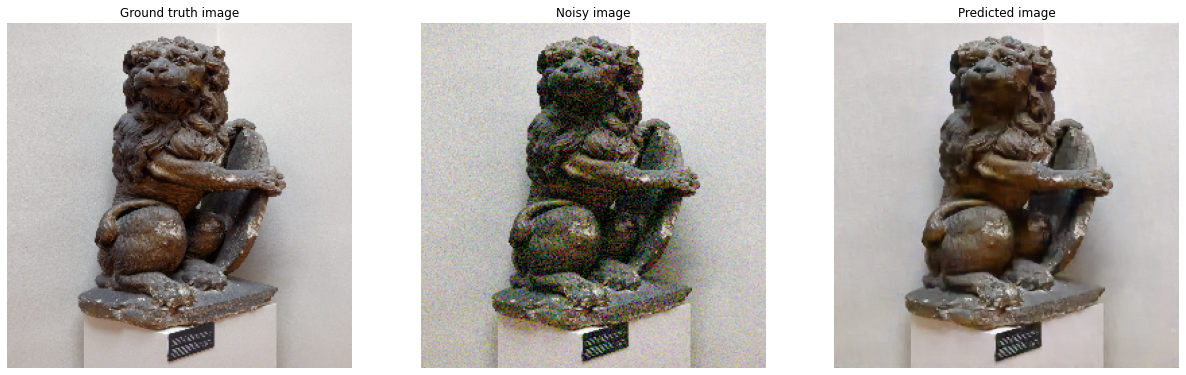

In [ ]:
gt_img_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/zzFinal Models/Test images/Statue_ground_truth.jpg"
noisy_img_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/zzFinal Models/Test images/Statue_noisy.jpg"
final_inference(model, noisy_img_path, gt_img_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


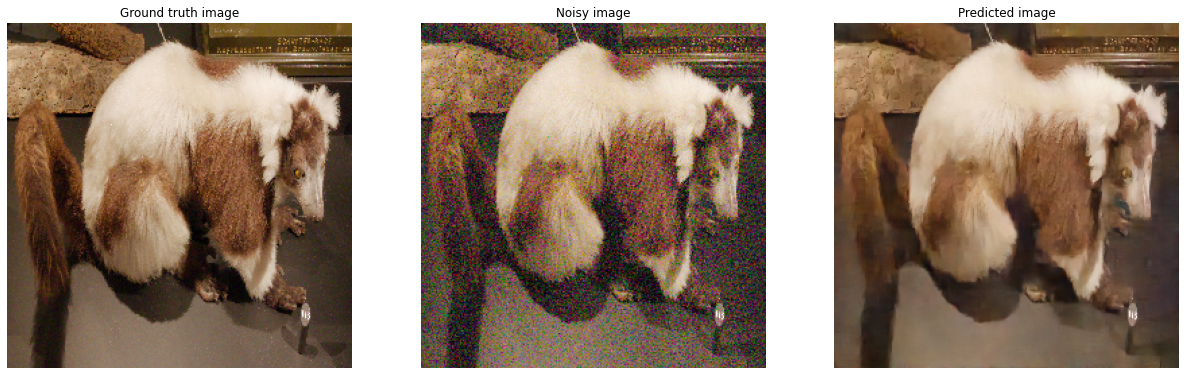

In [ ]:
gt_img_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/zzFinal Models/Test images/Museum_animal_ground_truth.jpg"
noisy_img_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/zzFinal Models/Test images/Museum_animal_noisy.jpg"
final_inference(model, noisy_img_path, gt_img_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


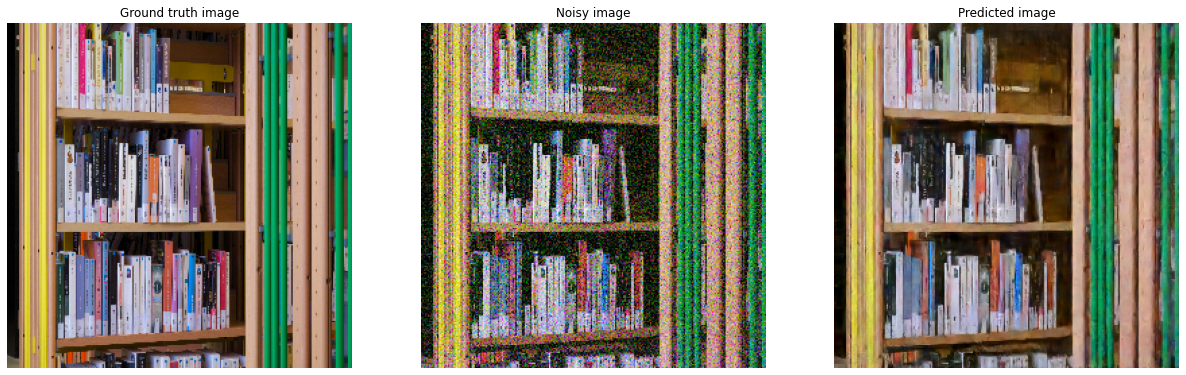

In [ ]:
gt_img_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/zzFinal Models/Test images/Library_ground_truth.png"
noisy_img_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/zzFinal Models/Test images/Library_noisy.png"
final_inference(model, noisy_img_path, gt_img_path)

## **<font color='green'>Final Metric**</font>

In [ ]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim

def final_metric_psnr(model, noisy_test_images, gt_test_images):
    predicted_images = model.predict(noisy_test_images)
    psnr_original_mean = 0
    psnr_prediction_mean = 0

    for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
        psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
        psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

    psnr_original_mean/=gt_test_images.shape[0]
    psnr_prediction_mean/=gt_test_images.shape[0]

    return psnr_original_mean, psnr_prediction_mean

def final_metric_ssim(model, noisy_test_images, gt_test_images):
    predicted_images = model.predict(noisy_test_images)
    ssim_original_mean = 0
    ssim_prediction_mean = 0

    for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
        ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
        ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

    ssim_original_mean/=gt_test_images.shape[0]
    ssim_prediction_mean/=gt_test_images.shape[0]

    return ssim_original_mean, ssim_prediction_mean

In [ ]:
psnr_original_mean, psnr_prediction_mean = final_metric_psnr(model, noisy_test_images, gt_test_images)
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 25.42818958777495
Predicted average gt-predicted PSNR -> 33.25970591830911


In [ ]:
ssim_original_mean, ssim_prediction_mean = final_metric_ssim(model, noisy_test_images, gt_test_images)
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.5419033823192735
Predicted average gt-predicted SSIM -> 0.8371697180851816


## **<font color='green'>Calculate time taken to predict**</font>

In [ ]:
# Load PRIDNet model
best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
model = tf.keras.models.load_model(best_models_path+'best_PRIDNet_blindnoise_256x256.h5', custom_objects={'Convolutional_block': Convolutional_block,
                                                                                                        'Channel_attention':Channel_attention,
                                                                                                        'Avg_pool_Unet_Upsample_msfe':Avg_pool_Unet_Upsample_msfe,
                                                                                                        'Multi_scale_feature_extraction':Multi_scale_feature_extraction,
                                                                                                        'Kernel_selecting_module':Kernel_selecting_module})

In [ ]:
%%time
noisy_image = cv2.imread(noisy_img_path)
noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB)
noisy_image = cv2.resize(noisy_image, (256, 256))
noisy_image = np.expand_dims(noisy_image, axis=0)
predicted_image = model.predict(noisy_image)[0]

CPU times: user 8.44 s, sys: 90.2 ms, total: 8.53 s
Wall time: 2.64 s


# **<font color='purple'>Key points considered for submission</font>**

In [ ]:
from prettytable import PrettyTable

pt = PrettyTable()
print("Note 1: Improvements shown are over original pairs")
print("Note 2: Time taken shown below is time taken to predict a single image")
pt.field_names = ["Model", "PSNR", "SSIM", "PSNR Improvement", "SSIM improvement", "Time taken (seconds)"]

pt.add_row(["Original X-y pairs (No Model)","26.3779","0.6000", "-", "-", "-"])
pt.add_row(["REDNet (Baseline)","30.5713","0.7932", "4.1934","0.1932", "~ 4.64"])
pt.add_row(["MWCNN (using Wavelets)","32.5220","0.8397","6.1441","0.2397", "~ 2.7"])
pt.add_row(["PRIDNet (using Attention)","33.3105","0.8534","6.9326","0.2534", "~ 2.64"])

print(pt)

Note 1: Improvements shown are over original pairs
Note 2: Time taken shown below is time taken to predict a single image
+-------------------------------+---------+--------+------------------+------------------+----------------------+
|             Model             |   PSNR  |  SSIM  | PSNR Improvement | SSIM improvement | Time taken (seconds) |
+-------------------------------+---------+--------+------------------+------------------+----------------------+
| Original X-y pairs (No Model) | 26.3779 | 0.6000 |        -         |        -         |          -           |
|       REDNet (Baseline)       | 30.5713 | 0.7932 |      4.1934      |      0.1932      |        ~ 4.64        |
|     MWCNN (using Wavelets)    | 32.5220 | 0.8397 |      6.1441      |      0.2397      |        ~ 2.7         |
|   PRIDNet (using Attention)   | 33.3105 | 0.8534 |      6.9326      |      0.2534      |        ~ 2.64        |
+-------------------------------+---------+--------+------------------+---------

<ul>
<li>I have implemented three different deep learning architectures for image denoising,
    <ul>
    <li>REDNet; <a href='https://arxiv.org/pdf/1606.08921.pdf'>https://arxiv.org/pdf/1606.08921.pdf</a></li>
    <li>Multi-level Wavelet CNN; <a href='https://arxiv.org/pdf/1805.07071.pdf'>https://arxiv.org/pdf/1805.07071.pdf</a></li>
    <li>PRIDNet; <a href='https://arxiv.org/pdf/1908.00273.pdf'>https://arxiv.org/pdf/1908.00273.pdf</a></li>
    </ul>
I found that <b>PRIDNet</b> was giving the best results as compared to the other two, giving me the best PSNR and SSIM scores along with best visualizations which were very close to the ground truth images.</li>
<li>Using PRIDNet, the average time taken to predict a single image is ~2.6 seconds which is the least as compared to other models.</li>
<li>I have implemented <i>final_inference</i> function which will predict a single image and display it along with the input noisy image and its ground truth.</li>
<li>I have also implemented two <i>final_metric</i> functions, one of which will output the average PSNR score and the other will output the average SSIM score.</li>
</ul>